# Concrete Strength Prediction Using Machine Learning (Complete)

* Given data about the composition and age of different concretes, we will have to predict the compressive strength of concrete.
* We will try out many models and pick the best one to make our predictions.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.svm import LinearSVR, SVR
# svm stands for Support Vector Machine
# LinearSVR is for linear problems and SVR is for non-linear problems.
# LinearSVR is faster than SVR.
# LinearSVR supports Linear Kernel and SVR supports RBF (Radio Basis Function) Kernel.
# RBF function is much better at detecting non-linear relationships than Linear Kernel.
from sklearn.tree import DecisionTreeRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor
# Ensemble methods are used to combine the predictions of multiple models to improve accuracy.
# RandomForestRegressor is an ensemble of decision trees that ultimately finds average of all the decisions and is used to reduce overfitting.
# GradientBoostingRegressor is an ensemble of weak prediction models, typically decision trees, that builds the model in a stage-wise fashion and is used to reduce bias.
# AdaBoostRegressor is an ensemble method that combines multiple weak learners to create a strong learner by focusing on the errors of previous models.
# Gradient Boosting Regressor is generally more robust and accurate than AdaBoostRegressor. But they both build models in a sequential manner.
# Advantage of AdaBoost is that it is less prone to overfitting than Gradient Boosting.
# Disadvantage of AdaBoost is that it is sensitive to noisy data and outliers.
# Advantage of Gradient Boosting is that it can handle complex data better than AdaBoost.
# Disadvantage of Gradient Boosting is that it is more prone to overfitting than AdaBoost.
# Adaboost updates the weights of unclassified points better while Gradient Boosting updates the residual errors better.
from sklearn.model_selection import KFold, GridSearchCV

In [2]:
data = pd.read_csv('Concrete_Data.csv')
data

,Cement (kg in a m^3 mixture),Blast Furnace Slag (kg in a m^3 mixture),Fly Ash (kg in a m^3 mixture),Water (kg in a m^3 mixture),Superplasticizer (kg in a m^3 mixture),Coarse Aggregate (kg in a m^3 mixture),Fine Aggregate (kg in a m^3 mixture),Age (day),Concrete compressive strength (Mpa)
0,540.0,0.0,0.0,162.0,2.5,1040.0,676.0,28,79.99
1,540.0,0.0,0.0,162.0,2.5,1055.0,676.0,28,61.89
2,332.5,142.5,0.0,228.0,0.0,932.0,594.0,270,40.27
3,332.5,142.5,0.0,228.0,0.0,932.0,594.0,365,41.05
4,198.6,132.4,0.0,192.0,0.0,978.4,825.5,360,44.30
...,...,...,...,...,...,...,...,...,...
1025,276.4,116.0,90.3,179.6,8.9,870.1,768.3,28,44.28
1026,322.2,0.0,115.6,196.0,10.4,817.9,813.4,28,31.18
1027,148.5,139.4,108.6,192.7,6.1,892.4,780.0,28,23.70
1028,159.1,186.7,0.0,175.6,11.3,989.6,788.9,28,32.77


In [3]:
#  To see if there are any missing values, we need to use the .info() function.

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1030 entries, 0 to 1029
Data columns (total 9 columns):
 #   Column                                    Non-Null Count  Dtype  
---  ------                                    --------------  -----  
 0   Cement (kg in a m^3 mixture)              1030 non-null   float64
 1   Blast Furnace Slag (kg in a m^3 mixture)  1030 non-null   float64
 2   Fly Ash (kg in a m^3 mixture)             1030 non-null   float64
 3   Water (kg in a m^3 mixture)               1030 non-null   float64
 4   Superplasticizer (kg in a m^3 mixture)    1030 non-null   float64
 5   Coarse Aggregate (kg in a m^3 mixture)    1030 non-null   float64
 6   Fine Aggregate (kg in a m^3 mixture)      1030 non-null   float64
 7   Age (day)                                 1030 non-null   int64  
 8   Concrete compressive strength (Mpa)       1030 non-null   float64
dtypes: float64(8), int64(1)
memory usage: 72.6 KB


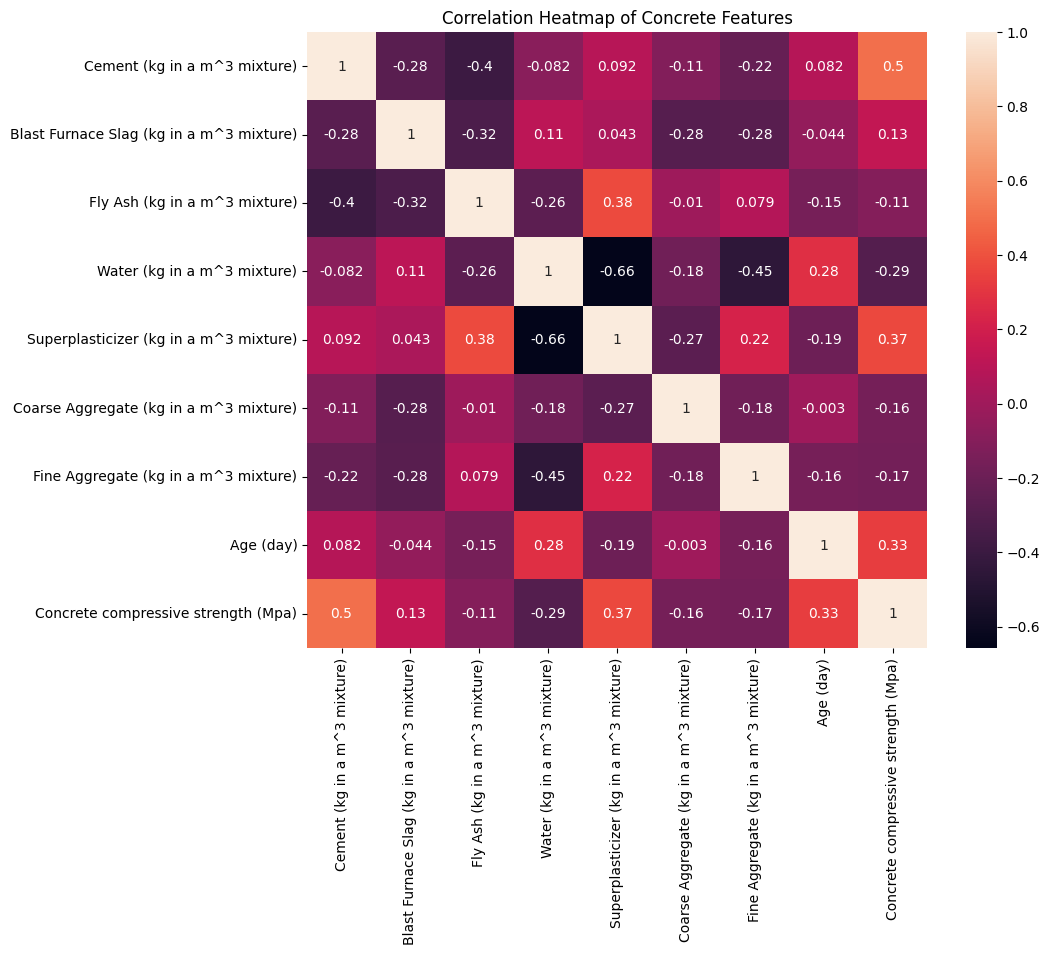

In [4]:
### PLOT ADDED HERE: Correlation heatmap
plt.figure(figsize=(10,8))
sns.heatmap(data.corr(), annot=True)
plt.title("Correlation Heatmap of Concrete Features")
plt.show()

# Preprocessing

In [5]:
def preprocess_inputs(df):
    df = df.copy()
# '''Separating the target column and feature set'''

# If we want to set the target column 'Concrete compressive strength (Mpa) from the rest of the dataset, we need to separate it.
    y = df['Concrete compressive strength (Mpa)'].copy()
# Now we have our target column in y.

# Now we can drop the target column from the dataset to create our feature set, or we have to keep the dataset as our feature set in x except the target column we put in y by dropping it.
    X = df.drop('Concrete compressive strength (Mpa)', axis = 1).copy()

# Then, we need to create the train and test sets, and we only want fit the scaler, that we will perform after this, to X, not to y.
# '''Train-test-split'''
    X_train, X_test, y_train, y_test = train_test_split(X,y, train_size = 0.7, random_state = 123)

# '''Scale X with a standard scaler:'''
    scaler = StandardScaler()
    scaler.fit(X_train)
    X_train = pd.DataFrame(scaler.transform(X_train), columns= X_train.columns)
    X_test = pd.DataFrame(scaler.transform(X_test), columns= X_test.columns)

    return X_train, X_test, y_train, y_test


''' What the standard scaler did was to make the each of columns in X_train have a mean of 0 and a standard deviation of 1. Also, by using .transform( ) function, we transformed the columns data into Numpy arrays.
To fix this, we used pd.DataFrame( ) function to convert the Numpy arrays back to DataFrames and set the columns names to be the same as the original X_train and X_test.'''

' What the standard scaler did was to make the each of columns in X_train have a mean of 0 and a standard deviation of 1. Also, by using .transform( ) function, we transformed the columns data into Numpy arrays.\nTo fix this, we used pd.DataFrame( ) function to convert the Numpy arrays back to DataFrames and set the columns names to be the same as the original X_train and X_test.'

In [6]:
X_train, X_test, y_train, y_test = preprocess_inputs(data)

In [7]:
X_train

,Cement (kg in a m^3 mixture),Blast Furnace Slag (kg in a m^3 mixture),Fly Ash (kg in a m^3 mixture),Water (kg in a m^3 mixture),Superplasticizer (kg in a m^3 mixture),Coarse Aggregate (kg in a m^3 mixture),Fine Aggregate (kg in a m^3 mixture),Age (day)
0,-0.858785,2.415833,-0.847354,0.475472,-1.034530,-0.549031,-0.704369,-0.677267
1,-0.649654,0.257904,-0.463043,-0.008664,0.083955,1.203924,0.179163,0.174174
2,0.273206,-0.856855,-0.847354,0.475472,-1.034530,0.508920,0.745693,1.202330
3,0.551408,-0.856855,-0.847354,0.146448,-1.034530,1.126701,-0.221864,-0.275644
4,1.107810,-0.856855,-0.847354,0.179350,-1.034530,0.877014,-0.472665,-0.613008
...,...,...,...,...,...,...,...,...
716,0.944727,0.222677,-0.847354,2.167599,-1.034530,-0.520716,-2.258826,2.166226
717,0.896761,-0.856855,-0.847354,0.193451,-1.034530,0.843551,-0.170940,-0.275644
718,1.039699,1.290846,-0.847354,-1.691390,2.638108,-0.357261,-0.198948,-0.613008
719,1.376418,0.351085,-0.847354,-1.432871,2.070519,-0.469234,0.410867,-0.613008


In [8]:
X_train.mean()

#  All the means of columns are close to 0. This is because of the standard scaler we used to scale the data.

Cement (kg in a m^3 mixture)               -4.878206e-16
Blast Furnace Slag (kg in a m^3 mixture)    2.463740e-17
Fly Ash (kg in a m^3 mixture)               7.883969e-17
Water (kg in a m^3 mixture)                 1.687662e-15
Superplasticizer (kg in a m^3 mixture)     -5.420229e-17
Coarse Aggregate (kg in a m^3 mixture)      1.660561e-15
Fine Aggregate (kg in a m^3 mixture)       -7.736145e-16
Age (day)                                  -3.572424e-17
dtype: float64

In [9]:
X_train.var()

#  All the variances of columns are close to 1. This is because of the Standard Scaler we used to scale the data.

Cement (kg in a m^3 mixture)                1.001389
Blast Furnace Slag (kg in a m^3 mixture)    1.001389
Fly Ash (kg in a m^3 mixture)               1.001389
Water (kg in a m^3 mixture)                 1.001389
Superplasticizer (kg in a m^3 mixture)      1.001389
Coarse Aggregate (kg in a m^3 mixture)      1.001389
Fine Aggregate (kg in a m^3 mixture)        1.001389
Age (day)                                   1.001389
dtype: float64

In [10]:
y_test

134     71.30
13      42.33
996     26.86
770     14.99
937     36.80
        ...  
702     17.17
378     43.06
1000    44.61
664     19.35
348     50.08
Name: Concrete compressive strength (Mpa), Length: 309, dtype: float64

# Model Selection

In [11]:
Models = {
    'Linear Regression': LinearRegression(),
    'L2(Ridge) Regression': Ridge(),
    'Support Vector Machine (Linear Kernel)': LinearSVR(),
    'Support Vector Machine (RBF Kernel)': SVR(),
    'Decision Tree': DecisionTreeRegressor(),
    'Neural Network': MLPRegressor(),
    'Random Forest': RandomForestRegressor(),
    'Gradient Boosting': GradientBoostingRegressor(),
    'Ada Boost': AdaBoostRegressor()
}

for name, model in Models.items():
    model.fit(X_train, y_train)
    print(name + " trained.")

Linear Regression trained.
L2(Ridge) Regression trained.
Support Vector Machine (Linear Kernel) trained.
Support Vector Machine (RBF Kernel) trained.
Decision Tree trained.


c:\Users\tanvi\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Neural Network trained.
Random Forest trained.
Gradient Boosting trained.
Ada Boost trained.


In [12]:
# For scoring the models, we will use the R^2 score and Mean Absolute Error (MAE).

for name, model in Models.items():
    print(name + " R^2 score: {:.5f}".format(model.score(X_test, y_test)))

Linear Regression R^2 score: 0.60111
L2(Ridge) Regression R^2 score: 0.60097
Support Vector Machine (Linear Kernel) R^2 score: 0.57088
Support Vector Machine (RBF Kernel) R^2 score: 0.63459
Decision Tree R^2 score: 0.83651
Neural Network R^2 score: 0.44292
Random Forest R^2 score: 0.89523
Gradient Boosting R^2 score: 0.90697
Ada Boost R^2 score: 0.80673


In [13]:
# The worst model is Neural Network with an R^2 score of 0.44648, and the best model is Gradient Boosting with an R^2 score of 0.90689.

# Now, we will need to optimize the Gradient Boosting Model using Hyperparameter Tuning with GridSearchCV.

C:\Users\tanvi\AppData\Local\Temp\ipykernel_22456\2573556658.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(scores.keys()), y=list(scores.values()), palette = 'plasma')


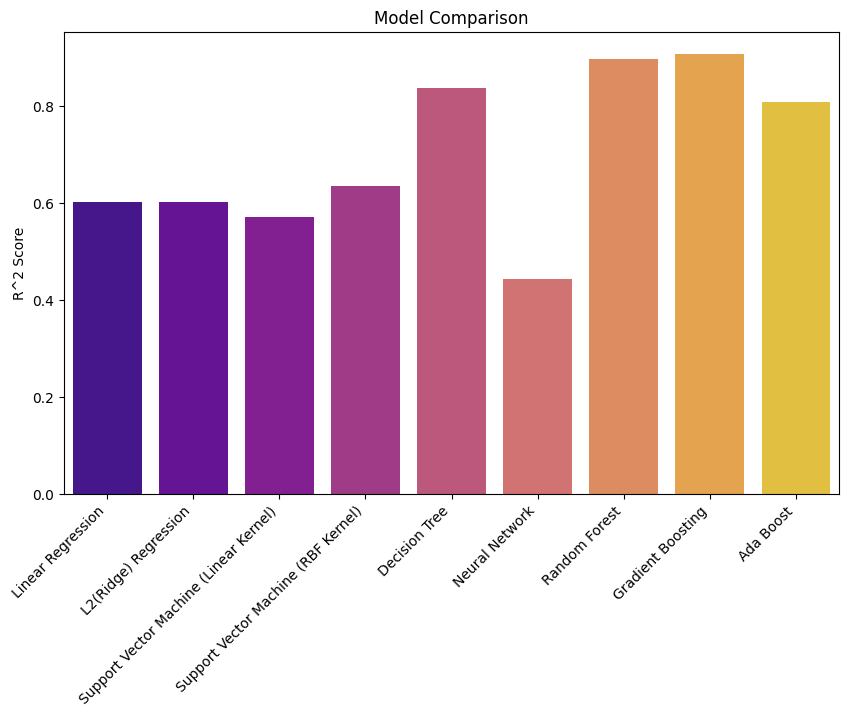

In [37]:
# Calculate R^2 scores for each model
scores = {name: model.score(X_test, y_test) for name, model in Models.items()}

### PLOT ADDED HERE: Model comparison bar chart
plt.figure(figsize=(10,6))
sns.barplot(x=list(scores.keys()), y=list(scores.values()), palette = 'plasma')
# There are more palette options in seaborn like 'coolwarm', 'plasma', 'inferno', 'magma', 'cividis', etc.
plt.xticks(rotation=45, ha="right")
plt.ylabel("R^2 Score")
plt.title("Model Comparison")
plt.show()

# Model Optimization

In [15]:
best_model = GradientBoostingRegressor()

best_model.fit(X_train, y_train)

print("Gradient Boosting R^2 score before optimization: {:.5f}".format(best_model.score(X_test, y_test)))

Gradient Boosting R^2 score before optimization: 0.90688


In [16]:
params = {
    'learning_rate': [0.01, 0.1, 1.0],
    'n_estimators': [100, 150, 200],
    'max_depth': [3, 4, 5]
}

clf = GridSearchCV(best_model, params)
clf.fit(X_train, y_train)
print("Best parameters found: ", clf.best_params_)

Best parameters found:  {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 200}


In [17]:
print("Gradient Boosting R^2 score after optimization: {:.5f}".format(clf.score(X_test, y_test)))

Gradient Boosting R^2 score after optimization: 0.92796


In [18]:
#  By optimizing the hyperparameters, we boosted the R^2 score from 0.90689 to 0.92757.

In [19]:
# Predictions on test data
y_pred = clf.predict(X_test)

# Compare actual vs predicted
results = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
print(results.head())

     Actual  Predicted
134   71.30  71.391721
13    42.33  47.739786
996   26.86  26.675478
770   14.99  14.140992
937   36.80  33.430151


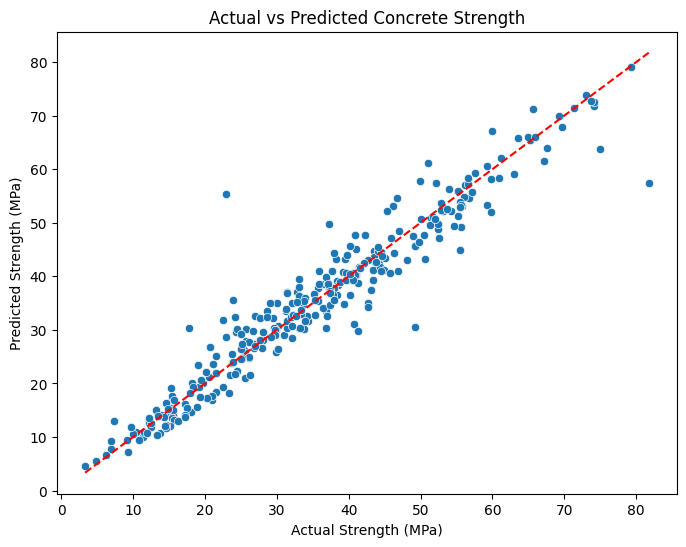

In [36]:
### PLOT ADDED HERE: Actual vs Predicted
plt.figure(figsize=(8,6))
sns.scatterplot(x=y_test, y=y_pred)
plt.xlabel("Actual Strength (MPa)")
plt.ylabel("Predicted Strength (MPa)")
plt.title("Actual vs Predicted Concrete Strength")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--')  # 45-degree line
plt.show()

In [22]:
# dataset features are in this order:
# ['Cement', 'Blast Furnace Slag', 'Fly Ash', 'Water', 'Superplasticizer', 'Coarse Aggregate', 'Fine Aggregate', 'Age']

In [23]:
# Evaluation metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


print("MAE:", mean_absolute_error(y_test, y_pred))
print("MSE:", mean_squared_error(y_test, y_pred))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))
print("R^2:", r2_score(y_test, y_pred))

MAE: 2.804281887105963
MSE: 19.008589360164507
RMSE: 4.3598840993958206
R^2: 0.9279568025140603


In [24]:
# Example new input (values must match the dataset order & scale)
new_mix = np.array([[540, 0, 0, 162, 2.5, 1040, 676, 28]])

# Fit scaler on training data if not available
scaler = StandardScaler()
scaler.fit(X_train)

# Scale input using the fitted scaler
new_mix_scaled = scaler.transform(new_mix)

# Predict compressive strength
predicted_strength = clf.predict(new_mix_scaled)
print("Predicted Concrete Strength (MPa):", predicted_strength[0])

Predicted Concrete Strength (MPa): 54.51653192131387


c:\Users\tanvi\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\tanvi\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  warnings.warn(
